In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

import utils
import constants

In [2]:
def drop_and_fill(data):
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.drop(["QGL", "T-JUS-CKGL"], axis=1)
    data = data.fillna(0)
    data = data.set_index("timestamp")
    
    return data

In [3]:
train_df = pd.DataFrame()

### Generate training dataset

Add normal sequences

In [4]:
train_normal, test_normal = utils.read_files(constants.FILE_PATH, classes=[constants.NORMAL_CLASS], real_only=True, test_size=0.5)

for file in tqdm(train_normal[:15]):
    data = pd.read_csv(file)
    data = drop_and_fill(data)
    data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    train_df = pd.concat([train_df, data])

100%|██████████| 15/15 [00:02<00:00,  6.14it/s]


Add normal sequences from abnormal files

In [5]:
train_abnormal, test_abnormal = utils.read_files(constants.FILE_PATH, classes=constants.ABNORMAL_CLASSES, real_only=True, test_size=0.5)

for file in tqdm(train_abnormal):
    data = pd.read_csv(file)
    data = drop_and_fill(data)

    # Get normal sequence
    data = data[data["class"] == 0]
    
    data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    train_df = pd.concat([train_df, data])

100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


In [6]:
# Store until when there are normal samples to create y_train later
normal_samples = len(train_df) / constants.STEPS

Add anomaly sequences

In [7]:
for file in tqdm(train_abnormal):
    data = pd.read_csv(file)
    data = drop_and_fill(data)

    # Get abnormal sequence
    data = data[data["class"] != 0]
    
    data = data.drop("class", axis=1)
    n_sequences = len(data) // constants.STEPS
    data = data.iloc[:n_sequences*constants.STEPS]
    train_df = pd.concat([train_df, data])

100%|██████████| 25/25 [00:05<00:00,  4.81it/s]


In [8]:
train_df = train_df.reset_index(drop=True)

<AxesSubplot:>

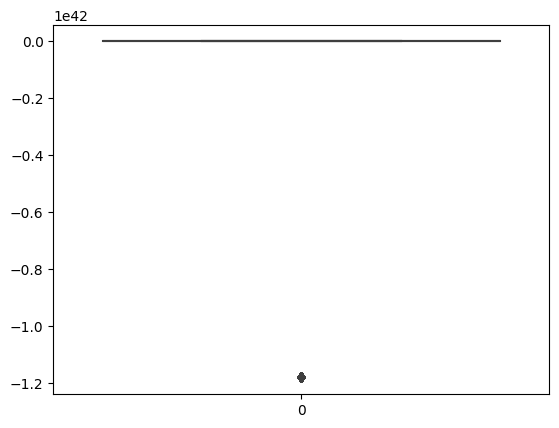

In [9]:
sns.boxplot(train_df["P-PDG"])

In [10]:
# Removing extreme outliers to improve standardization
train_df = train_df[train_df["P-PDG"] > -0.5*1e42]

In [11]:
scaler = sklearn.preprocessing.StandardScaler()
train = scaler.fit_transform(train_df)

In [12]:
train_sequences = utils.create_sequence(train)

In [13]:
x_train = np.empty(shape=(1, 5, 6))

for seq in tqdm(train_sequences):
    s_features = utils.get_features(seq).reshape((1, 5, 6))
    x_train = np.concatenate((x_train, s_features))

x_train = x_train.reshape(x_train.shape[0], 30)

100%|██████████| 12809/12809 [00:15<00:00, 811.72it/s] 


In [14]:
cols = []

for col in data.columns:
    for var in ["Mean", "Std", "Var", "Min", "Max"]:
        cols.append(col + " - " + var)

y_train = [0 if i < normal_samples else 1 for i in range(len(x_train))]

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier()

### Test

In [16]:
test_data = pd.read_csv(test_abnormal[3])
test_data = drop_and_fill(test_data)
test_data = test_data.drop("class", axis=1)
test_data_preprocessed = scaler.transform(test_data)

test_sequences = utils.create_sequence(test_data_preprocessed)

x_test = np.empty(shape=(0, 5, 6))

for seq in test_sequences:
    s_features = utils.get_features(seq).reshape((1, 5, 6))
    x_test = np.concatenate((x_test, s_features))

x_test = x_test.reshape(x_test.shape[0], 30)

In [17]:
preds = knn.predict(x_test)
preds = np.repeat(preds, constants.STEPS)

# Remove leftover out of sequences
test_data = test_data.iloc[:len(preds)]

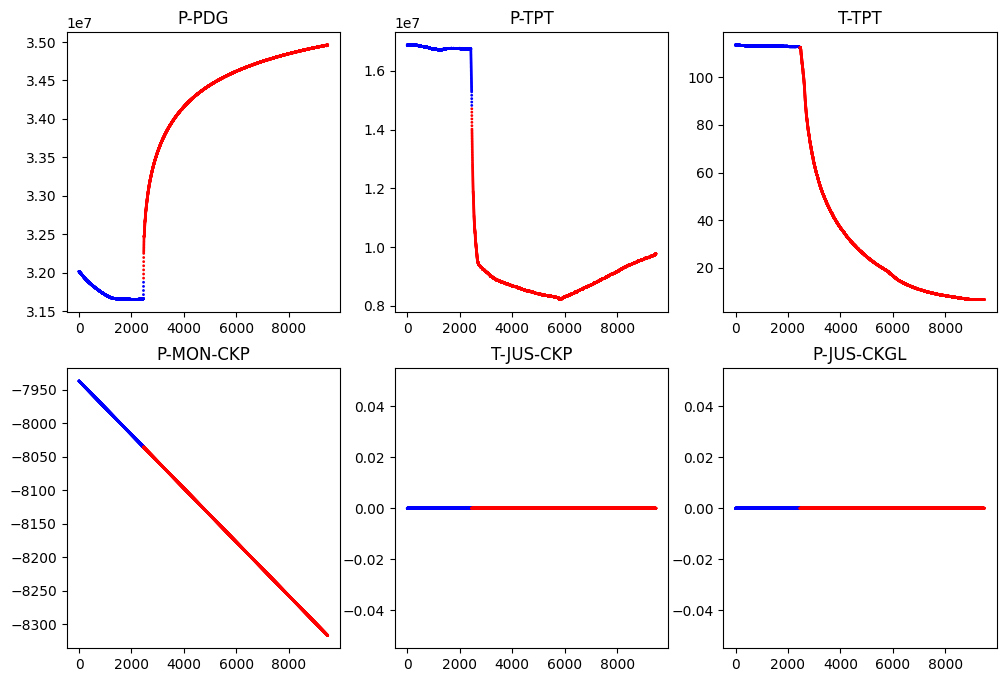

In [18]:
rows = 2
cols = 3

f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))

columns = test_data.columns

# Normal = Blue
# Anomaly = Red
colors = ["blue" if pred == 0 else "red" for pred in preds]

for i in range(rows):
    for j in range(cols):
        ax[i][j].scatter(x=range(len(test_data)), y=test_data[columns[i*(rows+1) + j]].values, c=colors, s=1)
        ax[i][j].set_title(columns[i*(rows+1) + j])